In [ ]:
!pip install -qq transformers

In [ ]:
import pandas as pd
import numpy as np
import re
from transformers import BertModel, BertTokenizer, AdamW
import torch
from torch import nn
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import confusion_matrix, classification_report
from torch.utils.data import Dataset, DataLoader, TensorDataset
from functools import reduce
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
warnings.filterwarnings('ignore')

# Params
data_name = 'OE'
drop_out = 0.3
seed = 0
n_folds = 5
model_name = 'bert-base-cased'
batch_size = 32
device = 'cuda'
n_classes = 3
n_epochs = 10
lr = 5e-5
note = 'deduplicated-extra'

In [ ]:
data_whole = pd.read_csv('/content/drive/My Drive/CSCW_H1/data/OE_labeled.csv')
data_extra = pd.read_csv('/content/drive/My Drive/CSCW_H1/data/OE_labeled_extra.csv')
data_whole = pd.concat([data_whole, data_extra])
data_whole = data_whole[~data_whole['Label'].isna()].reset_index(drop=True)
data_whole['Label'] = data_whole['Label'].astype(int)
len(data_whole)

1098

In [ ]:
def anyalnum(string):
  return any(char.isalnum() for char in string)

def preprocess(tweet):
  tweet = tweet.replace('@ ','@').replace('# ','#')
  tweet = re.sub('pic.twitter.com.*','',tweet)
  tweet = re.sub('https*://[^\s]+','',tweet)
  tweet = re.sub('https*://.*','',tweet)
  # tweet = ' '.join(word for word in tweet.split() if anyalnum(word))
  return tweet

data_whole['processed_tweet'] = data_whole['tweet'].apply(preprocess)
data = data_whole.drop_duplicates('processed_tweet').reset_index(drop=True)
data.sample(1)

,tweet,Label,cashtags,conversation_id,created_at,date,day,favorites,geo,has_media,hashtags,hour,id,img_urls,is_replied,is_reply_to,likes,link,links,mentions,name,near,nlikes,nreplies,nretweets,parent_tweet_id,place,quote_url,replies,reply_to,reply_to_users,retweet,retweet_date,retweet_id,retweets,screen_name,search,source,text_html,timestamp_epochs,timezone,trans_dest,trans_src,translate,tweet_id,user_id,user_id_str,user_rt,user_rt_id,username,video_url,lang,ZLabel,TLabel,RLabel,"(1, 'ZLabel')","(148, 'ZLabel')","(7, 'TLabel')","(349, 'TLabel')","(118, 'RLabel')","(665, 'RLabel')",Unnamed: 0,Unnamed: 0.1,corrected_id,pred_new,pred_old,processed_tweet
142,# OddEven is nothing to do with environmental...,0,NaN,NaN,NaN,2017-11-09 17:24,NaN,0.0,NaN,NaN,# # # #,NaN,9.290000e+17,NaN,NaN,NaN,NaN,https://twitter.com/RajeshGuwahati/status/9285...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,RajeshGuwahati,NaN,en,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,# OddEven is nothing to do with environmental ...


In [ ]:
print('number of tweets', len(data_whole))
print('number of deduplicated tweets', len(data_whole.drop_duplicates('tweet')))
print('number of deduplicated tweets after processing', len(data))
data.Label.value_counts()

number of tweets 1098
number of deduplicated tweets 1096
number of deduplicated tweets after processing 1093


1    668
2    238
0    187
Name: Label, dtype: int64

In [ ]:
tokenizer = BertTokenizer.from_pretrained(model_name)
# find max length of tokenized sequence
max_len = 0
for each in data.processed_tweet:
  tmp_len = tokenizer.tokenize(each)
  if max_len < len(tmp_len):
    max_len = len(tmp_len)
print(max_len)


151


In [ ]:
class DatasetClass(Dataset):
  def __init__(self, tweets, labels, tokenizer, max_len):
    self.tweets = tweets
    self.labels = labels
    self.tokenizer = tokenizer
    self.max_len = max_len

  def __len__(self):
    return len(self.tweets)

  def __getitem__(self, item):
    tweet = str(self.tweets[item])
    label = self.labels[item]
    encoding = self.tokenizer.encode_plus(
      tweet,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      pad_to_max_length=True,
      return_attention_mask=True,
      return_tensors='pt',
      truncation = True,
    )
    return {
      'tweet_text': tweet,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'labels': torch.tensor(label, dtype=torch.long)
    }

def create_data_loader(df, index, tokenizer, max_len, batch_size):
  tmp_df = df.loc[index]
  data = DatasetClass(
    tweets=tmp_df.processed_tweet.to_numpy(),
    labels=tmp_df.Label.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )
  return DataLoader(
    data,
    batch_size=batch_size,
    num_workers=4
  )

In [ ]:
data_dict = {i:{'train':None, 'test':None, 'val':None} for i in range(n_folds)}
splitter = KFold(n_splits=n_folds, shuffle=True, random_state=seed)
for fold, (train_val_ind, test_ind) in enumerate(splitter.split(data.index)):
  train_ind, val_ind = train_test_split(train_val_ind, random_state=seed, test_size=0.20)
  data_dict[fold]['train'] = create_data_loader(data, train_ind, tokenizer, max_len, batch_size)
  data_dict[fold]['val'] = create_data_loader(data, val_ind, tokenizer, max_len, batch_size)
  data_dict[fold]['test'] = create_data_loader(data, test_ind, tokenizer, max_len, batch_size)

In [ ]:
class SentimentClassifier(nn.Module):
  def __init__(self, n_classes, drop_out):
    super(SentimentClassifier, self).__init__()
    self.bert = BertModel.from_pretrained(model_name)
    self.drop = nn.Dropout(p=drop_out)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)

  def forward(self, input_ids, attention_mask):
    _, output = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask
    )
    output = self.drop(output)
    return self.out(output)

## Extract last hidden state of first token as per
http://jalammar.github.io/a-visual-guide-to-using-bert-for-the-first-time/

In [ ]:
torch.manual_seed(seed)
embed_dict = {i:{'train_X':None,'val_X':None,'test_X':None,'train_y':None,'val_y':None,'test_y':None} for i in range(n_folds)}
model = SentimentClassifier(n_classes, drop_out).to(device)
model.eval()
for fold in range(n_folds):
  train_data = data_dict[fold]['train']
  train_embeds = []
  train_labels = []
  val_data = data_dict[fold]['val']
  val_embeds = []
  val_labels = []
  test_data = data_dict[fold]['test']
  test_embeds = []
  test_labels = []
  # Train
  for batch in train_data:
    input_ids = batch["input_ids"].to(device)
    attention_mask = batch["attention_mask"].to(device)
    train_labels.append(batch["labels"])
    train_embeds.append(model.bert(input_ids, attention_mask)[0][:,0,:].cpu().detach().numpy())
    # Val
  for batch in val_data:
    input_ids = batch["input_ids"].to(device)
    attention_mask = batch["attention_mask"].to(device)
    val_labels.append(batch["labels"])
    val_embeds.append(model.bert(input_ids, attention_mask)[0][:,0,:].cpu().detach().numpy())
    # Test
  for batch in test_data:
    input_ids = batch["input_ids"].to(device)
    attention_mask = batch["attention_mask"].to(device)
    test_labels.append(batch["labels"])
    test_embeds.append(model.bert(input_ids, attention_mask)[0][:,0,:].cpu().detach().numpy())
  embed_dict[fold]['train_X'] = np.concatenate(train_embeds)
  embed_dict[fold]['val_X'] = np.concatenate(val_embeds)
  embed_dict[fold]['test_X'] = np.concatenate(test_embeds)
  embed_dict[fold]['train_y'] = np.concatenate(train_labels)
  embed_dict[fold]['val_y'] = np.concatenate(val_labels)
  embed_dict[fold]['test_y'] = np.concatenate(test_labels)
  print(embed_dict[fold]['train_X'].shape, embed_dict[fold]['val_X'].shape, embed_dict[fold]['test_X'].shape)
  print(embed_dict[fold]['train_y'].shape, embed_dict[fold]['val_y'].shape, embed_dict[fold]['test_y'].shape)
print(embed_dict[fold]['test_X'][-1][-1]) # 0.031285353
pd.to_pickle(embed_dict, '/content/drive/My Drive/CSCW_H1/data/embeds_OE_extra.pickle')


(699, 768) (175, 768) (219, 768)
(699,) (175,) (219,)
(699, 768) (175, 768) (219, 768)
(699,) (175,) (219,)
(699, 768) (175, 768) (219, 768)
(699,) (175,) (219,)
(700, 768) (175, 768) (218, 768)
(700,) (175,) (218,)
(700, 768) (175, 768) (218, 768)
(700,) (175,) (218,)
-0.12060376


In [ ]:
torch.manual_seed(seed)

model = SentimentClassifier(n_classes, drop_out)
model = model.to(device)
init_state = model.state_dict()
optimizer = AdamW(model.parameters(), lr=lr)
loss_fn = nn.CrossEntropyLoss().to(device)

train_outs = {i:{'pred_y':[],'y':[],'loss':[]} for i in range(n_folds)}
val_outs = {i:{'pred_y':[],'y':[],'loss':[],'optim_epoch':None,'optim_loss':None} for i in range(n_folds)}

for fold in range(n_folds):
  torch.cuda.empty_cache()
  model.load_state_dict(init_state)

  train_data = data_dict[fold]['train']
  val_data = data_dict[fold]['val']
  global_val_loss = np.inf

  for epoch in range(n_epochs):
    # Training
    model.train()
    train_epoch_loss = []
    for batch in train_data:
      optimizer.zero_grad()

      outputs = model(batch["input_ids"].to(device),
                      batch["attention_mask"].to(device),
      )
      _, preds = torch.max(outputs, dim=1)

      train_outs[fold]['pred_y'].extend(preds.detach().cpu().tolist())
      train_outs[fold]['y'].extend(batch["labels"].tolist())
      
      loss = loss_fn(outputs, batch["labels"].to(device))
      train_epoch_loss.append(loss.item())
      loss.backward()
      optimizer.step()
    print('Train','fold=',fold,'iter=',epoch,'loss=',np.mean(train_epoch_loss))
    train_outs[fold]['loss'].append(np.mean(train_epoch_loss))

    # Validation
    model.eval()
    val_epoch_loss = []
    for batch in val_data:

      outputs = model(batch["input_ids"].to(device),
                      batch["attention_mask"].to(device),
      )
      _, preds = torch.max(outputs, dim=1)

      val_outs[fold]['pred_y'].extend(preds.detach().cpu().tolist())
      val_outs[fold]['y'].extend(batch["labels"].tolist())
      
      loss = loss_fn(outputs, batch["labels"].to(device))
      val_epoch_loss.append(loss.item())
    mean_val_loss = np.mean(val_epoch_loss)
    val_outs[fold]['loss'].append(mean_val_loss)
    if mean_val_loss < global_val_loss:
      torch.save(model.state_dict(), '/content/model'+str(fold))
      val_outs[fold]['optim_epoch'] = epoch
      val_outs[fold]['optim_loss'] = mean_val_loss
      global_val_loss = mean_val_loss
    print('Val','fold=',fold,'iter=',epoch,'loss=',mean_val_loss,
          'optim_loss=',global_val_loss,'optim_epoch=',val_outs[fold]['optim_epoch'])

Train fold= 0 iter= 0 loss= 1.0106762105768377
Val fold= 0 iter= 0 loss= 0.9890547692775726 optim_loss= 0.9890547692775726 optim_epoch= 0
Train fold= 0 iter= 1 loss= 0.8660465722734277
Val fold= 0 iter= 1 loss= 0.9299410184224447 optim_loss= 0.9299410184224447 optim_epoch= 1
Train fold= 0 iter= 2 loss= 0.687894416126338
Val fold= 0 iter= 2 loss= 0.9663444310426712 optim_loss= 0.9299410184224447 optim_epoch= 1
Train fold= 0 iter= 3 loss= 0.4105969511649825
Val fold= 0 iter= 3 loss= 1.4333795607089996 optim_loss= 0.9299410184224447 optim_epoch= 1
Train fold= 0 iter= 4 loss= 0.3953711813823743
Val fold= 0 iter= 4 loss= 1.1181551218032837 optim_loss= 0.9299410184224447 optim_epoch= 1
Train fold= 0 iter= 5 loss= 0.22402812980792738
Val fold= 0 iter= 5 loss= 1.1248331467310588 optim_loss= 0.9299410184224447 optim_epoch= 1
Train fold= 0 iter= 6 loss= 0.10255270646038381
Val fold= 0 iter= 6 loss= 1.4124468763669331 optim_loss= 0.9299410184224447 optim_epoch= 1
Train fold= 0 iter= 7 loss= 0.069

In [ ]:
# Testing
test_outs = {i:{'pred_proba':[],'pred_y':[],'y':[]} for i in range(n_folds)}
model_dict = {i:None for i in range(n_folds)}
model = SentimentClassifier(n_classes, drop_out).to(device)
for fold in range(n_folds):
  model.load_state_dict(torch.load('/content/model'+str(fold)))
  model.eval()
  test_data = data_dict[fold]['test']
  for batch in test_data:
    input_ids = batch["input_ids"].to(device)
    attention_mask = batch["attention_mask"].to(device)
    labels = batch["labels"].to(device)

    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )
    _, preds = torch.max(outputs, dim=1)
    test_outs[fold]['pred_proba'].extend(outputs.detach().cpu().tolist())
    test_outs[fold]['pred_y'].extend(preds.detach().cpu().tolist())
    test_outs[fold]['y'].extend(batch["labels"].tolist())
  model_dict[fold] = model.state_dict()
  print(model_dict[fold]['out.bias'])
  continue
  print('fold=',fold)

tensor([-0.0121, -0.0214,  0.0345], device='cuda:0')
tensor([-0.0118, -0.0214,  0.0342], device='cuda:0')
tensor([-0.0116, -0.0212,  0.0338], device='cuda:0')
tensor([-0.0116, -0.0213,  0.0339], device='cuda:0')
tensor([-0.0118, -0.0213,  0.0341], device='cuda:0')


In [ ]:
test_pred_proba_all = reduce(lambda x,y: x+y, [test_outs[i]['pred_proba'] for i in range(n_folds)])
test_pred_y_all = reduce(lambda x,y: x+y, [test_outs[i]['pred_y'] for i in range(n_folds)])
test_y_all = reduce(lambda x,y: x+y, [test_outs[i]['y'] for i in range(n_folds)])
print(classification_report(test_y_all, test_pred_y_all))

              precision    recall  f1-score   support

           0       0.96      0.81      0.88       187
           1       0.91      0.98      0.94       668
           2       0.91      0.82      0.86       238

    accuracy                           0.91      1093
   macro avg       0.92      0.87      0.89      1093
weighted avg       0.92      0.91      0.91      1093



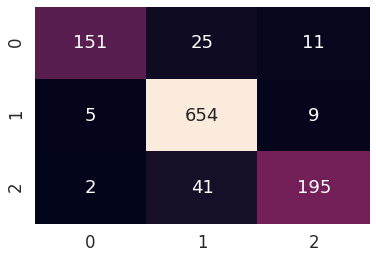

In [ ]:
sns.set(font_scale=1.5)
sns.heatmap(confusion_matrix(test_y_all, test_pred_y_all), 
            annot=True, cbar=False, fmt='g');

In [ ]:
final_dict = {'data_name':data_name,
              'seed':seed,
              'n_folds':n_folds,
              'model_name':model_name,
              'batch_size':batch_size,
              'drop_out':drop_out,
              'device':device,
              'n_classes':n_classes,
              'n_epochs':n_epochs,
              'lr':lr,
              'note':note,
              'train_outs':train_outs,
              'val_outs':val_outs,
              'test_outs':test_outs,
              'Classification_report':classification_report(test_y_all, test_pred_y_all)
              }
f_name = '_'.join(map(str,[data_name, seed, n_folds, model_name, batch_size, drop_out, device, n_classes, n_epochs, 
                           lr, note]))
pd.to_pickle(final_dict, '/content/drive/My Drive/CSCW_H1/results/'+f_name)
# for f_i in range(n_folds):
#   torch.save(model_dict[f_i], '/content/drive/My Drive/CSCW_H1/results/models_'+f_name+str(f_i))
f_name

'OE_0_5_bert-base-cased_32_0.3_cuda_3_10_5e-05_deduplicated-extra'

In [ ]:
for i in range(n_folds):
  print(model_dict[i]['out.bias'])

tensor([-0.0122, -0.0213,  0.0348], device='cuda:0')
tensor([-0.0122, -0.0213,  0.0348], device='cuda:0')
tensor([-0.0122, -0.0213,  0.0348], device='cuda:0')
tensor([-0.0122, -0.0213,  0.0348], device='cuda:0')
tensor([-0.0122, -0.0213,  0.0348], device='cuda:0')


## Predicting over larger dataset

In [ ]:
# Load entire dataset of OddEven here

big_data = pd.read_csv('/content/drive/My Drive/CSCW_H1/data/OE_english.csv')
len(big_data)

80343

In [ ]:
big_data['processed_tweet'] = big_data.tweet.apply(preprocess)
def tokenize(x):
    tweet = x
    encoding = tokenizer.encode_plus(
      tweet,
      add_special_tokens=True,
      max_length=max_len,
      return_token_type_ids=False,
      pad_to_max_length=True,
      return_attention_mask=True,
      return_tensors='pt',
      truncation = True,
    )
    return {
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
    }
big_data['tokenized'] = big_data['processed_tweet'].apply(lambda x: tokenize(x))

In [ ]:
big_data['input_ids'] = big_data['tokenized'].apply(lambda x: x['input_ids'].tolist())
big_data['attention_mask'] = big_data['tokenized'].apply(lambda x: x['attention_mask'].tolist())

In [ ]:
big_dataloader = DataLoader(TensorDataset(torch.tensor(big_data['input_ids']), 
                                          torch.tensor(big_data['attention_mask'])), batch_size=32)

In [ ]:
from IPython.display import clear_output
#model = SentimentClassifier(n_classes, drop_out).to(device)
model.eval()
for fold in range(n_folds):
  print(fold)
  model.load_state_dict(torch.load('/content/model'+str(fold)))
  print(model.state_dict()['out.bias'])
  #continue
  outs = []
  for b_i,batch in enumerate(big_dataloader):
    #clear_output(wait=True)
    print('fold',fold, b_i,'of',len(big_dataloader))
    output = model(batch[0].to(device), batch[1].to(device)).cpu().detach().tolist()
    outs.extend(output)
  big_data['test_r_'+str(fold)] = outs
big_data.to_csv('/content/drive/My Drive/CSCW_H1/results/big_data_OE_extra.csv', index=None)

Streaming output truncated to the last 5000 lines.
fold 3 25 of 2511
fold 3 26 of 2511
fold 3 27 of 2511
fold 3 28 of 2511
fold 3 29 of 2511
fold 3 30 of 2511
fold 3 31 of 2511
fold 3 32 of 2511
fold 3 33 of 2511
fold 3 34 of 2511
fold 3 35 of 2511
fold 3 36 of 2511
fold 3 37 of 2511
fold 3 38 of 2511
fold 3 39 of 2511
fold 3 40 of 2511
fold 3 41 of 2511
fold 3 42 of 2511
fold 3 43 of 2511
fold 3 44 of 2511
fold 3 45 of 2511
fold 3 46 of 2511
fold 3 47 of 2511
fold 3 48 of 2511
fold 3 49 of 2511
fold 3 50 of 2511
fold 3 51 of 2511
fold 3 52 of 2511
fold 3 53 of 2511
fold 3 54 of 2511
fold 3 55 of 2511
fold 3 56 of 2511
fold 3 57 of 2511
fold 3 58 of 2511
fold 3 59 of 2511
fold 3 60 of 2511
fold 3 61 of 2511
fold 3 62 of 2511
fold 3 63 of 2511
fold 3 64 of 2511
fold 3 65 of 2511
fold 3 66 of 2511
fold 3 67 of 2511
fold 3 68 of 2511
fold 3 69 of 2511
fold 3 70 of 2511
fold 3 71 of 2511
fold 3 72 of 2511
fold 3 73 of 2511
fold 3 74 of 2511
fold 3 75 of 2511
fold 3 76 of 2511
fold 3 77 of 